# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. 

| Variable Name | Description  | Variable Type |
|------|-----|-----|
| SalesID   | unique identifier of a particular sale of a machine at auction  | Independent  variable |
| MachineID  | identifier for a particular machine; machines may have multiple sales  | Independent  variable |
| ModelID | identifier for a unique machine model (i.e. fiModelDesc) | Independent  variable |
| datasource  | source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs. | Independent  variable |
| auctioneerID  | identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource.  | Independent  variable |
| YearMade  | year of manufacturer of the Machine  | Independent  variable |
| MachineHoursCurrentMeter | current usage of the machine in hours at time of sale (saledate); null or 0 means no hours have been reported for that sale | Independent  variable |
| UsageBand | value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel; e.g. 'Low' means this machine has fewer hours given its lifespan relative to the average of fiBaseModel. | Independent  variable |
| Saledate   | time of sale | Independent  variable |
| fiModelDesc  | Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor  | Independent  variable |
| State | US State in which sale occurred | Independent  variable |
| Drive_System | machine configuration; typically describes whether 2 or 4 wheel drive  | Independent  variable |
| Enclosure  | machine configuration - does the machine have an enclosed cab or not | Independent  variable |
| Forks  | machine configuration - attachment used for lifting  | Independent  variable |
| Pad_Type | machine configuration - type of treads a crawler machine uses | Independent  variable |
| Ride_Control  | machine configuration - optional feature on loaders to make the ride smoother | Independent  variable |
| Transmission | machine configuration - describes type of transmission; typically automatic or manual | Independent  variable |
| ... | ... | ... |
| SalePrice | cost of sale in USD | Target/dependent variable |

You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
# Timestamp
import datetime

import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-02-09 13:49:20.421005


## 1. Importing the data and preparing it for modelling

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

pandas version: 2.2.3
NumPy version: 2.1.3
Matplotlib version: 3.10.0


In [3]:
# Import the training and validation set
df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df["saledate"][:10]

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
5    12/18/2008 0:00
6     8/26/2004 0:00
7    11/17/2005 0:00
8     8/27/2009 0:00
9      8/9/2007 0:00
Name: saledate, dtype: object

Text(0, 0.5, 'Sale Price ($)')

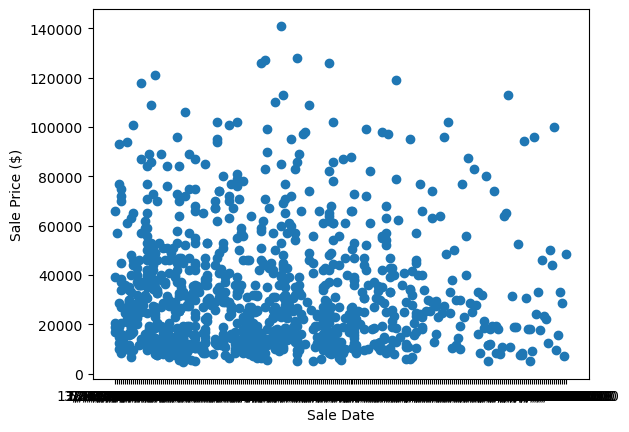

In [6]:
fig, ax = plt.subplots()
ax.scatter(x=df["saledate"][:1000],
           y=df["SalePrice"][:1000])
ax.set_xlabel("Sale Date")
ax.set_ylabel("Sale Price ($)")

<Axes: xlabel='Sale Price ($)', ylabel='Frequency'>

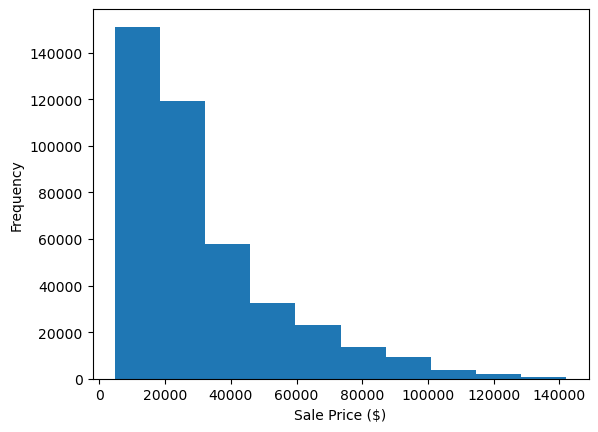

In [7]:
# View SalePrice distribution
df.SalePrice.plot.hist(xlabel="Sale Price ($)")

In [8]:
df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [9]:
df["saledate"][:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

Text(0, 0.5, 'Sale Price ($)')

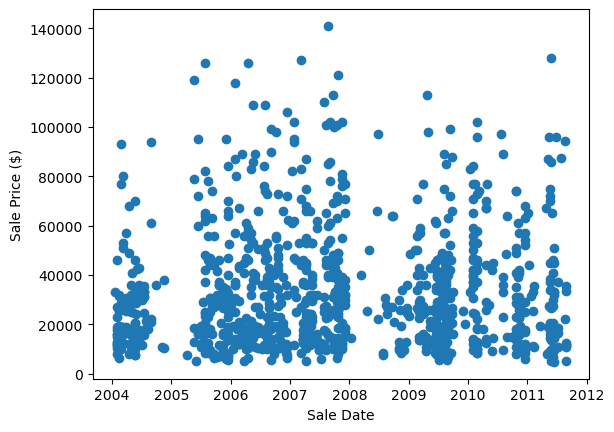

In [10]:
fig, ax = plt.subplots()
ax.scatter(x=df["saledate"][:1000],
           y=df["SalePrice"][:1000])
ax.set_xlabel("Sale Date")
ax.set_ylabel("Sale Price ($)")

In [11]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(10), df.saledate.tail(10)

(205615   1989-01-17
 274835   1989-01-31
 141296   1989-01-31
 212552   1989-01-31
 62755    1989-01-31
 54653    1989-01-31
 81383    1989-01-31
 204924   1989-01-31
 135376   1989-01-31
 113390   1989-01-31
 Name: saledate, dtype: datetime64[ns],
 409202   2012-04-28
 408976   2012-04-28
 411695   2012-04-28
 411319   2012-04-28
 408889   2012-04-28
 410879   2012-04-28
 412476   2012-04-28
 411927   2012-04-28
 407124   2012-04-28
 409203   2012-04-28
 Name: saledate, dtype: datetime64[ns])

In [12]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

In [13]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

In [14]:
# look at newly created columns
df_tmp[["SalePrice", "saleYear", "saleMonth", "saleDay", "saleDayofweek", "saleDayofyear"]].head()

,SalePrice,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,9500.0,1989,1,17,1,17
274835,14000.0,1989,1,31,1,31
141296,50000.0,1989,1,31,1,31
212552,16000.0,1989,1,31,1,31
62755,22000.0,1989,1,31,1,31


Text(0, 0.5, 'Sale Price ($)')

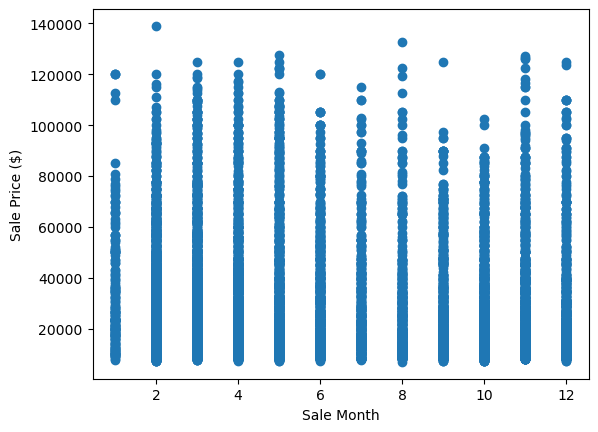

In [15]:
fig, ax = plt.subplots()
ax.scatter(x=df_tmp["saleMonth"][:10000],
           y=df_tmp["SalePrice"][:10000])

ax.set_xlabel("Sale Month")
ax.set_ylabel("Sale Price ($)")

Text(0, 0.5, 'Median Sale Price ($)')

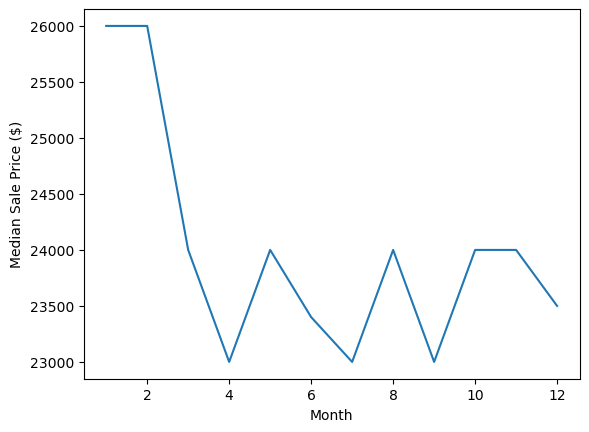

In [16]:
# Group DataFrame by saleMonth and then find the median SalePrice
df_tmp.groupby(["saleMonth"])["SalePrice"].median().plot()
plt.xlabel("Month")
plt.ylabel("Median Sale Price ($)")

In [17]:
df_tmp.state.value_counts()[:10]

state
Florida        67320
Texas          53110
California     29761
Washington     16222
Georgia        14633
Maryland       13322
Mississippi    13240
Ohio           12369
Illinois       11540
Colorado       11529
Name: count, dtype: int64

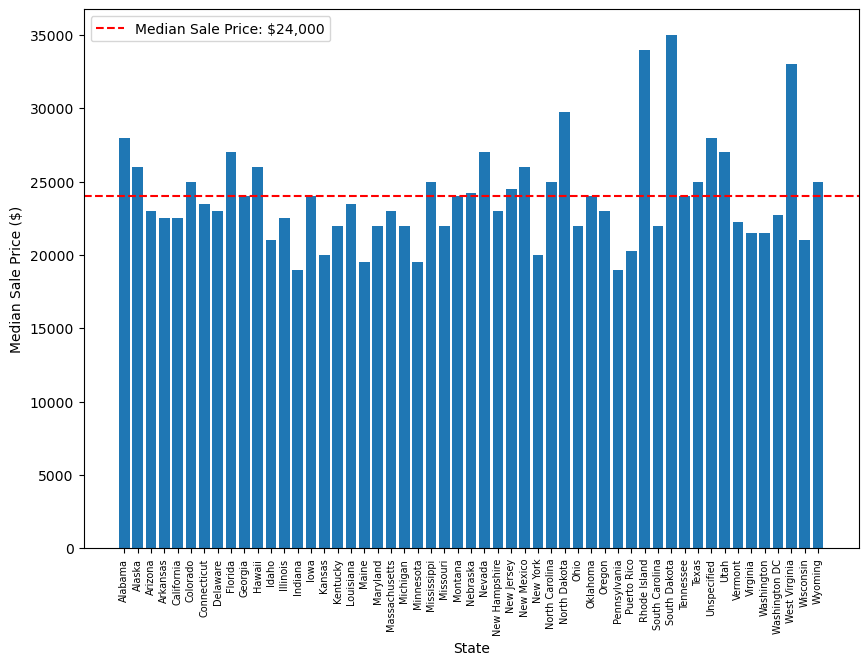

In [18]:
# Group DataFrame by saleMonth and then find the median SalePrice per state as well as across the whole dataset
median_prices_by_state = df_tmp.groupby(["state"])["SalePrice"].median()
median_sale_price = df_tmp["SalePrice"].median()

# Create a plot comparing median sale price per state to median sale price overall
plt.figure(figsize=[10, 7])
plt.bar(x=median_prices_by_state.index,
        height=median_prices_by_state.values)
plt.xlabel("State")
plt.ylabel("Median Sale Price ($)")
plt.xticks(rotation=90, fontsize=7);
plt.axhline(y=median_sale_price,
            color="red",
            linestyle="--",
            label=f"Median Sale Price: ${median_sale_price:,.0f}")
plt.legend();

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)
model.fit(X=df_tmp.drop("SalePrice", axis=1),
          y=df_tmp.SalePrice)

ValueError: could not convert string to float: 'Low'

some features of data are still in string format

In [20]:
# Check for missing values and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [21]:
df_tmp.head().isna()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,True,False,False,False,False,False
274835,False,False,False,False,False,False,False,True,True,False,...,True,True,True,False,False,False,False,False,False,False
141296,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,True,False,False,False,False,False
212552,False,False,False,False,False,False,False,True,True,False,...,True,True,True,False,False,False,False,False,False,False
62755,False,False,False,False,False,False,False,True,True,False,...,False,False,False,True,True,False,False,False,False,False


In [22]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [23]:
df_tmp["UsageBand"].dtype, df_tmp["UsageBand"].dtype.name

(dtype('O'), 'object')

In [24]:
pd.api.types.is_object_dtype(df_tmp["UsageBand"])

True

In [25]:
pd.api.types.is_string_dtype(df_tmp["state"])

True

In [26]:
# Print column names and example content of columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

Column name: fiModelDesc | Column dtype: object | Example value: ['580M'] | Example value dtype: string
Column name: fiBaseModel | Column dtype: object | Example value: ['920'] | Example value dtype: string
Column name: fiProductClassDesc | Column dtype: object | Example value: ['Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons'] | Example value dtype: string
Column name: state | Column dtype: object | Example value: ['North Carolina'] | Example value dtype: string
Column name: ProductGroup | Column dtype: object | Example value: ['SSL'] | Example value dtype: string
Column name: ProductGroupDesc | Column dtype: object | Example value: ['Skid Steer Loaders'] | Example value dtype: string


In [27]:
# Start a count of how many object type columns there are
number_of_object_type_columns = 0

for label, content in df_tmp.items():
    # Check to see if column is of object type (this will include the string column) 
    if pd.api.types.is_object_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

        number_of_object_type_columns += 1

print(f"\n[INFO] Total number of object type columns: {number_of_object_type_columns}")

Column name: UsageBand | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiModelDesc | Column dtype: object | Example value: ['EX60URG'] | Example value dtype: string
Column name: fiBaseModel | Column dtype: object | Example value: ['IT28'] | Example value dtype: string
Column name: fiSecondaryDesc | Column dtype: object | Example value: ['G'] | Example value dtype: string
Column name: fiModelSeries | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiModelDescriptor | Column dtype: object | Example value: ['LC'] | Example value dtype: string
Column name: ProductSize | Column dtype: object | Example value: [nan] | Example value dtype: empty
Column name: fiProductClassDesc | Column dtype: object | Example value: ['Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity'] | Example value dtype: string
Column name: state | Column dtype: object | Example value: ['Wyoming'] | Example value dtype: string
Column nam

In [28]:
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = df_tmp[label].astype("category")

In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [30]:
df_tmp.state.dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=False, categories_dtype=object)

In [31]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [32]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [33]:
# save preprocessed data to file
df_tmp.to_csv("data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.csv",
              index=False)

In [34]:
# Import preprocessed data to file
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.csv",
                     low_memory=False)
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [35]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [36]:
# again convert object columns to category datatype
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = df_tmp[label].astype("category")

In [37]:
pip install pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.


In [38]:
df_tmp.to_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet",
                  engine="auto")

In [39]:
df_tmp = pd.read_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet",
                         engine="auto")
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [40]:
df_tmp.isna().sum().sort_values(ascending=False)[:20]

Blade_Width          386715
Enclosure_Type       386715
Engine_Horsepower    386715
Tip_Control          386715
Pushblock            386715
Blade_Extension      386715
Scarifier            386704
Grouser_Tracks       367823
Hydraulics_Flow      367823
Coupler_System       367724
fiModelSeries        354031
Steering_Controls    341176
Differential_Type    341134
UsageBand            339028
fiModelDescriptor    337882
Backhoe_Mounting     331986
Turbocharged         331602
Stick                331602
Pad_Type             331602
Blade_Type           330823
dtype: int64

In [41]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        # Check datatype of target column
        column_datatype = df_tmp[label].dtype.name

        # Get random sample from column values
        example_value = content.sample(1).values

        # Infer random sample datatype
        example_value_dtype = pd.api.types.infer_dtype(example_value)
        print(f"Column name: {label} | Column dtype: {column_datatype} | Example value: {example_value} | Example value dtype: {example_value_dtype}")

Column name: SalesID | Column dtype: int64 | Example value: [2269432] | Example value dtype: integer
Column name: SalePrice | Column dtype: float64 | Example value: [26000.] | Example value dtype: floating
Column name: MachineID | Column dtype: int64 | Example value: [524763] | Example value dtype: integer
Column name: ModelID | Column dtype: int64 | Example value: [3406] | Example value dtype: integer
Column name: datasource | Column dtype: int64 | Example value: [172] | Example value dtype: integer
Column name: auctioneerID | Column dtype: float64 | Example value: [3.] | Example value dtype: floating
Column name: YearMade | Column dtype: int64 | Example value: [1970] | Example value dtype: integer
Column name: MachineHoursCurrentMeter | Column dtype: float64 | Example value: [0.] | Example value dtype: floating
Column name: saleYear | Column dtype: int64 | Example value: [2009] | Example value dtype: integer
Column name: saleMonth | Column dtype: int64 | Example value: [2] | Example 

In [42]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(f"Column name: {label} | Has missing values: {True}")
        else:
            print(f"Column name: {label} | Has missing values: {False}")

Column name: SalesID | Has missing values: False
Column name: SalePrice | Has missing values: False
Column name: MachineID | Has missing values: False
Column name: ModelID | Has missing values: False
Column name: datasource | Has missing values: False
Column name: auctioneerID | Has missing values: True
Column name: YearMade | Has missing values: False
Column name: MachineHoursCurrentMeter | Has missing values: True
Column name: saleYear | Has missing values: False
Column name: saleMonth | Has missing values: False
Column name: saleDay | Has missing values: False
Column name: saleDayofweek | Has missing values: False
Column name: saleDayofyear | Has missing values: False


In [43]:
# Fill missing numeric values with the median of the target column
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():

            # Add a binary column which tells if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int)

            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())

In [44]:
df_tmp[df_tmp["MachineHoursCurrentMeter_is_missing"] == 1].sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
1746,1389854,47500.0,1215414,3883,132,99.0,1981,0.0,NaN,988B,...,NaN,Standard,Conventional,1989,4,15,5,105,0,1
4003,1597642,9500.0,1160549,8089,132,18.0,1979,0.0,NaN,410,...,NaN,NaN,NaN,1989,10,21,5,294,0,1
221145,1395674,132500.0,516901,3377,132,1.0,1998,0.0,NaN,163H,...,NaN,NaN,NaN,2007,2,27,1,58,0,1
406826,6300631,62000.0,1822928,26190,149,2.0,2005,0.0,NaN,SK210LC-6E,...,NaN,NaN,NaN,2012,3,7,2,67,0,1
135948,1379638,30000.0,253984,4329,132,1.0,1995,0.0,NaN,IT24F,...,NaN,Standard,Conventional,2002,10,1,1,274,0,1


In [45]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(f"Column name: {label} | Has missing values: {True}")
        else:
            print(f"Column name: {label} | Has missing values: {False}")

Column name: SalesID | Has missing values: False
Column name: SalePrice | Has missing values: False
Column name: MachineID | Has missing values: False
Column name: ModelID | Has missing values: False
Column name: datasource | Has missing values: False
Column name: auctioneerID | Has missing values: False
Column name: YearMade | Has missing values: False
Column name: MachineHoursCurrentMeter | Has missing values: False
Column name: saleYear | Has missing values: False
Column name: saleMonth | Has missing values: False
Column name: saleDay | Has missing values: False
Column name: saleDayofweek | Has missing values: False
Column name: saleDayofyear | Has missing values: False
Column name: auctioneerID_is_missing | Has missing values: False
Column name: MachineHoursCurrentMeter_is_missing | Has missing values: False


In [46]:
# Check columns which aren't numeric
print(f"[INFO] Columns which are not numeric:")
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(f"Column name: {label} | Column dtype: {df_tmp[label].dtype.name}")

[INFO] Columns which are not numeric:
Column name: UsageBand | Column dtype: category
Column name: fiModelDesc | Column dtype: category
Column name: fiBaseModel | Column dtype: category
Column name: fiSecondaryDesc | Column dtype: category
Column name: fiModelSeries | Column dtype: category
Column name: fiModelDescriptor | Column dtype: category
Column name: ProductSize | Column dtype: category
Column name: fiProductClassDesc | Column dtype: category
Column name: state | Column dtype: category
Column name: ProductGroup | Column dtype: category
Column name: ProductGroupDesc | Column dtype: category
Column name: Drive_System | Column dtype: category
Column name: Enclosure | Column dtype: category
Column name: Forks | Column dtype: category
Column name: Pad_Type | Column dtype: category
Column name: Ride_Control | Column dtype: category
Column name: Stick | Column dtype: category
Column name: Transmission | Column dtype: category
Column name: Turbocharged | Column dtype: category
Column n

In [47]:
# dictionary to store column to category values (e.g. we turn our category types into numbers but we keep a record so we can go back)
column_to_category_dict = {}

# Turn categorical variables into numbers
for label, content in df_tmp.items():
    # Check columns which aren't numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int)
        # Ensure content is categorical and get its category codes
        content_categories = pd.Categorical(content)
        content_category_codes = content_categories.codes + 1
        # Add column key to dictionary with code: category mapping per column
        column_to_category_dict[label] = dict(zip(content_category_codes, content_categories))
        # Set column to numerical values
        df_tmp[label] = content_category_codes

In [48]:
df_tmp.sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
51295,1622391,13750.0,1116435,4602,132,2.0,1990,0.0,0,496,...,1,1,1,1,1,1,1,1,1,1
385206,1215028,22500.0,1061218,4606,121,3.0,1999,0.0,0,504,...,1,1,1,1,1,1,1,1,1,1
386811,6258610,16000.0,1796640,13260,149,1.0,2000,0.0,0,1115,...,1,1,1,1,1,1,1,1,1,1
87604,1620977,16000.0,1143306,4792,132,2.0,1989,0.0,0,1315,...,1,1,1,1,1,1,1,1,1,1
345980,4512354,22500.0,2386403,1177,136,1.0,1000,0.0,0,564,...,0,0,0,0,0,1,1,1,1,1


In [49]:
# Check the first 10 state column values
for key, value in sorted(column_to_category_dict["state"].items())[:10]:
    print(f"{key} -> {value}")

1 -> Alabama
2 -> Alaska
3 -> Arizona
4 -> Arkansas
5 -> California
6 -> Colorado
7 -> Connecticut
8 -> Delaware
9 -> Florida
10 -> Georgia


In [50]:
# Check total number of missing values
total_missing_values = df_tmp.isna().sum().sum()
print(f"[INFO] Total missing values: {total_missing_values}")

[INFO] Total missing values: 0


In [51]:
df_tmp.to_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet",
                  engine="auto")

In [52]:
df_tmp = pd.read_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet",
                         engine="auto")

In [53]:
# Check total number of missing values
total_missing_values = df_tmp.isna().sum().sum()
print(f"[INFO] Total missing values: {total_missing_values}")

[INFO] Total missing values: 0


# Fitting a machine learning model to our preprocessed data

In [54]:
%%time

# Sample 1000 samples with random state 42 for reproducibility
df_tmp_sample_1k = df_tmp.sample(n=1000, random_state=42)

model = RandomForestRegressor(n_jobs=-1)

X_sample_1k = df_tmp_sample_1k.drop("SalePrice", axis=1)
y_sample_1k = df_tmp_sample_1k["SalePrice"]

model.fit(X=X_sample_1k,
          y=y_sample_1k)

CPU times: user 2.83 s, sys: 60.2 ms, total: 2.89 s
Wall time: 900 ms


RandomForestRegressor(n_jobs=-1)

In [55]:
model_sample_1k_score = model.score(X=X_sample_1k,
                                    y=y_sample_1k)
print(f"[INFO] Model score on {len(df_tmp_sample_1k)} samples: {model_sample_1k_score}")

[INFO] Model score on 1000 samples: 0.9574905599881048


# Splitting data into the right train/validation sets

In [56]:
train_df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/Train.csv",
                       parse_dates=["saledate"],
                       low_memory=False).sort_values(by="saledate", ascending=True)

valid_df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/Valid.csv",
                       parse_dates=["saledate"])

valid_solution = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/ValidSolution.csv")

valid_df = valid_df.sort_values("saledate", ascending=True).reset_index(drop=True)

print(f"[INFO] Number of samples in training DataFrame: {len(train_df)}")
print(f"[INFO] Number of samples in validation DataFrame: {len(valid_df)}")

[INFO] Number of samples in training DataFrame: 401125
[INFO] Number of samples in validation DataFrame: 11573


In [57]:
train_df.sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
243830,1751771,15000,1212077,553,132,99.0,1992,NaN,NaN,2000-07-10,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
39891,1279607,65000,1207140,13279,132,1.0,2003,NaN,NaN,2007-06-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
286183,2199810,25000,1732015,6865,136,NaN,1993,0.0,NaN,2009-04-21,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
271722,1811464,18500,1438705,17318,132,1.0,2004,1227.0,Medium,2008-11-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373707,2697536,44000,1434670,16662,149,27.0,2005,6538.0,Medium,2010-12-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [58]:
def add_datetime_features_to_df(df, date_column="saledate"):
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear

    df.drop("saledate", axis=1, inplace=True)
    return df

train_df = add_datetime_features_to_df(df=train_df)
valid_df = add_datetime_features_to_df(df=valid_df)

In [59]:
train_df.iloc[:, -5:].sample(5)

,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
273173,2005,12,29,3,363
178371,2001,12,12,2,346
129231,1991,2,5,1,36
188782,2000,3,2,3,62
226908,2008,3,27,3,87


# Trying to fit a model on our training data

In [60]:
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]

X_valid = valid_df.drop("SalePrice", axis=1)
y_valid = valid_df["SalePrice"]

model = RandomForestRegressor(n_jobs=-1)

model.fit(X=X_train,
          y=y_train)

KeyError: "['SalePrice'] not found in axis"

In [ ]:
numerical_features = [label for label, content in X_train.items() if pd.api.types.is_numeric_dtype(content)]
categorical_features = [label for label, content in X_train.items() if not pd.api.types.is_numeric_dtype(content)]

print(f"[INFO] Numeric features: {numerical_features}")
print(f"[INFO] Categorical features: {categorical_features[:10]}...")

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories="auto",
                                 handle_unknown="use_encoded_value",
                                 unknown_value=np.nan,
                                 encoded_missing_value=np.nan)

X_train_preprocessed = X_train.copy()
X_train_preprocessed[categorical_features] = ordinal_encoder.fit_transform(X_train_preprocessed[categorical_features].astype(str))

X_valid_preprocessed = X_valid.copy()
X_valid_preprocessed[categorical_features] = ordinal_encoder.transform(X_valid_preprocessed[categorical_features].astype(str))

In [ ]:
X_train.head()

In [ ]:
X_train_preprocessed.head()

In [ ]:
X_train[categorical_features].isna().sum().sort_values(ascending=False)[:10]

In [ ]:
X_train_preprocessed[categorical_features].isna().sum().sort_values(ascending=False)[:10]

In [ ]:
ordinal_encoder.categories_[:3]

In [ ]:
column_to_category_mapping = {}

for column_name, category_values in zip(categorical_features, ordinal_encoder.categories_):
    int_to_category = {i: category for i, category in enumerate(category_values)}
    column_to_category_mapping[column_name] = int_to_category

column_to_category_mapping["UsageBand"]

# Fitting the model to preprocessed training data

In [ ]:
%%time

model = RandomForestRegressor(n_jobs=-1)
model.fit(X=X_train_preprocessed,
          y=y_train)

In [ ]:
%%time
model.score(X=X_valid_preprocessed,
            y=y_valid)

In [ ]:
%%time
model.score(X=X_train_preprocessed,
            y=y_train)

In [ ]:
X_valid_preprocessed[categorical_features].isna().sum().sort_values(ascending=False)[:10]

In [ ]:
X_valid_preprocessed = X_valid.copy()
X_valid_preprocessed[categorical_features] = ordinal_encoder.transform(X_valid_preprocessed[categorical_features].astype(str))

In [ ]:
X_valid_preprocessed[categorical_features].isna().sum().sort_values(ascending=False)[:10]